# Magnificent Seven ETF Analysis

### Spring 2024 Data Science Project
### By: Dhruv Dewan, Anish Nandyala, Adithya Prashanth

### Introduction

In today's fast-paced financial environment, navigating the stock market's continuously changing waves can feel like high-stakes gambling. With fortunes climbing and falling in a split second, investors constantly seek the keys to predictability and profitability. The concept of Exchange-Traded Funds (ETFs) has provided a diversified avenue for investment, offering exposure to a basket of assets within a single fund. Among these, the Magnificent Seven ETF (from Roundhill Investments) stands out, comprising seven tech giants: Apple, Amazon, Meta (formerly Facebook), Alphabet (Google), Tesla, Nvidia, and Microsoft. It is well known that tech stocks in general are very volatile and prone to great change. With the risk that this volatility brings, it accompanies great potential for profit as well. That is what our motivation for this project stems from.

Our project aims to harness the power of machine learning to discover the hidden features of stock prediction. At its core, we aim to address a fundamental question: Can we leverage historical stock data, technical indicators, and other features to forecast the future performance of the Magnificent Seven ETF with machine learning?

In a market where volatility rules the market, the ability to anticipate price movements with a degree of accuracy holds great value. Successful predictions empower investors to make informed decisions, mitigate risks, and capitalize on opportunities for profit. Furthermore, in the realm of ETFs, where the fortunes of multiple companies are intertwined, the stakes are even higher, and the potential rewards even more enticing. To achieve our goal, we will dive into the realm of technical analysis, a cornerstone of financial forecasting. By identifying and utilizing key technical indicators, widely recognized in the finance industry, we aim to construct a robust framework for predicting the future performance of the Magnificent Seven ETF. From moving averages to relative strength index (RSI), these indicators offer valuable insights into market trends, momentum, and sentiment, serving as the foundation upon which our predictive models will be built.

In summary, our project not only aims to create our own stock prediction model for the MAG7, but also to demonstrate the transformative potential of machine learning in revolutionizing investment strategies.


In [2]:
# Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import scipy
import warnings

# import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas_ta as ta

# interactive plot stuff
import plotly.graph_objects as go
import plotly

## Data Curation

In Python, the `yfinance` library serves as a valuable tool for accessing financial data from Yahoo Finance. The download function from yfinance is used to retrieve historical market data pertaining to the Magnificent Seven ETF, by its ticker symbol `'MAGS'`. The period of time specified is 1 year, because the MAG7 ETF has only existed since last April, and for the purpose of our project it makes sense to have data for a year for clean comparisons. Upon execution, the resulting dataset, representing the Magnificent Seven ETF's historical market activity, is stored in a pandas DataFrame format. We get a succinct preview of the first few rows using .head(), to get insight into the structure and content of the retrieved data.

In [3]:
mag7_data = yf.download('MAGS', period='1y')

[*********************100%%**********************]  1 of 1 completed


We first check the count of rows in our dataframe.

In [4]:
print(mag7_data.count())

Open         252
High         252
Low          252
Close        252
Adj Close    252
Volume       252
dtype: int64


Below we clean our data by dropping NA values and duplicates, just in case to have clean data prepped for comparisons, testing, and analysis. 

In [5]:
mag7_data = mag7_data.dropna()
mag7_data = mag7_data.drop_duplicates()

The plot displays the adjusted close prices of the Magnificent Seven ETF over one year, illustrating its performance over time. Adjusted close prices are chosen for their ability to account for corporate actions like stock splits and dividends, ensuring accurate historical representation because they take into account after market changes. This metric provides a smooth, consistent view of the ETF's performance, allowing us to make easy comparisons and analysis of investment returns. By focusing on adjusted close prices, the plot emphasizes the ETF's overall performance, capturing both capital appreciation and dividend distributions within the one-year timeframe.

Text(0.5, 1.0, 'Adjusted Close of Magnificent Seven ETF over time')

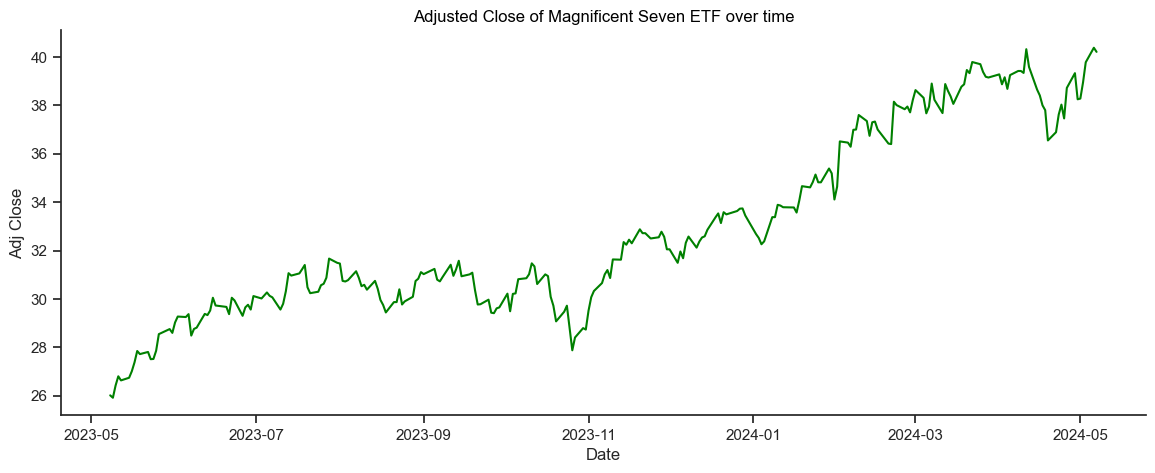

In [6]:
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=mag7_data, x="Date", y='Adj Close', color='green')
sns.despine()
plt.title("Adjusted Close of Magnificent Seven ETF over time", size='medium', color='black')

Below we describe our dataframe and that provides a concise statistical summary of the Magnificent Seven ETF's historical market data. It includes essential metrics like count, mean, standard deviation, minimum, maximum, and quartiles for the adjusted close prices. This summary offers quick insights into the distribution and characteristics of the ETF's performance, aiding in analysis and decision-making for investment strategies.

In [7]:
mag7_data.describe()

Open        High         Low       Close   Adj Close  \
count  252.000000  252.000000  252.000000  252.000000  252.000000   
mean    32.922198   33.137565   32.626996   32.883524   32.799326   
std      3.693590    3.719679    3.598969    3.673566    3.726901   
min     25.882000   26.129999   25.882000   26.030001   25.917496   
25%     30.204999   30.288751   29.908249   30.172500   30.042091   
50%     31.625000   31.835000   31.353500   31.604000   31.467403   
75%     36.417500   36.697500   36.000000   36.429998   36.429998   
max     40.450001   40.494400   40.030102   40.380001   40.380001   

             Volume  
count  2.520000e+02  
mean   8.497429e+04  
std    1.248652e+05  
min    5.000000e+02  
25%    4.375000e+03  
50%    3.140000e+04  
75%    1.306250e+05  
max    1.282400e+06

Downloading stock data for TSM (Taiwan Semiconductor Manufacturing Company) is motivated with the intention to explore its relationship with Nvidia's and Apple's stock performance. This correlation investigation is particularly important because Nvidia and Apple sources its Graphics Processing Units (GPUs) from TSM. By analyzing the stock data of both companies, we aim to discern patterns, trends, and potential interactions between their respective stock prices. Understanding this relationship can offer valuable insights for our prediction since some weightage of the Magnificent Seven comes from Nvidia. In addition to TSM, we downloaded data on Emerson Electric (EMR), which is Tesla's key supplier, and we aim to utilize that correlation as part of the model as well. Lastly, we have downloaded Intel data due to their involvement in the semiconductor industry. Several Mag 7 companies can directly be influenced by Intel's movement and in our EDA, we can test this correlation.

In [8]:
tsm_data = yf.download('TSM', period='1y')
emr_data = yf.download('EMR', period='1y')
intel_data = yf.download('INTC', period='1y')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Exploratory Data Analysis

Now that we have data that is ready to be used for analysis, we can start exploring this data to find high level relationships between the featuers of each dataset, and find comparisons between the different datasets we have chosen.

#### Hypothesis Testing

We can evaluate the relationship between the MAGS stock and Emerson Electric, Co. (EMR) in the same way. We start by graphing the adjusted close data for the past year of both of these stocks.

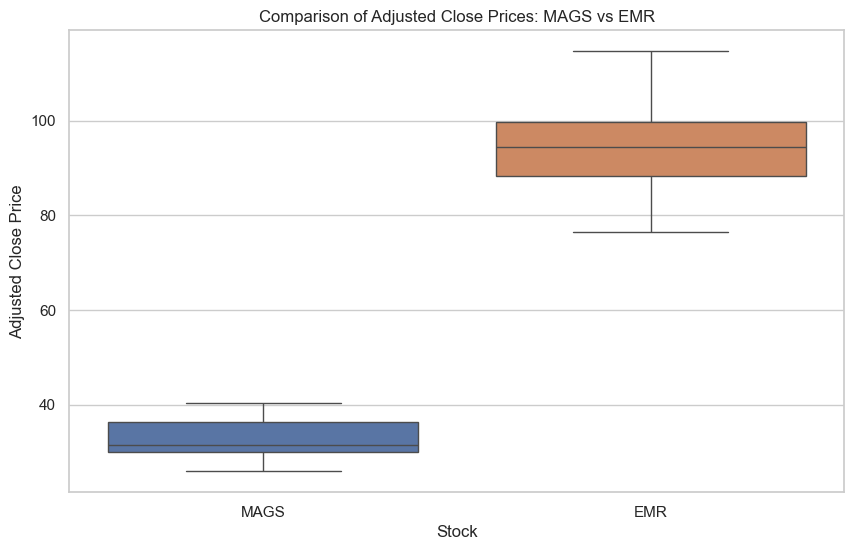

In [9]:
combined_data = pd.concat([mag7_data['Adj Close'], emr_data['Adj Close']], axis=1)
combined_data.columns = ['MAGS', 'EMR']

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.boxplot(data=combined_data)
plt.title('Comparison of Adjusted Close Prices: MAGS vs EMR')
plt.xlabel('Stock')
plt.ylabel('Adjusted Close Price')
plt.show()

First, we want to check how the MAGS stock compares to the TSM stock due to the relationship mentioned above between Nvidia and TSM. We can first start off by checking how different these two distributions are. We can accomplish this by using a two-sample T-test.

Our hypothesis are listed below:

*Null Hypothesis*: There is no significant difference between the average adjusted close prices of the MAGS and TSM stocks over the last year.

*Alternative Hypothesis*: The average adjusted close prices of the stocks MAGS and TSM significantly diverge from each other over the last year.

In [10]:
t_stat, p_value = scipy.stats.ttest_ind(mag7_data['Adj Close'], tsm_data['Adj Close'])
print("T-statistic:", t_stat)
print("P-Value: ", p_value)

T-statistic: -60.47918742593394
P-Value:  1.1760002475076922e-232


We reject the null hypothesis as the p-value is much less than 0.05, which is our significance level (alpha). Let's visualize this difference in distribution for both these stocks.

The hypothesis test simply shows that there is a large difference in the valuation of each stock. To fully gain more insight, we can move on to a correlation between the stocks to see if their movement is similar. If they are correlated in their movement, the TSM stock can be a great feature to use, as we can track it to gain certain insights into the value of the Magnificent Seven ETF.

#### Correlation Testing

Next, we can move on to see instead how the trends of these two stocks correlate over the past year. Let's first visualize the trends of each of the stocks individually.

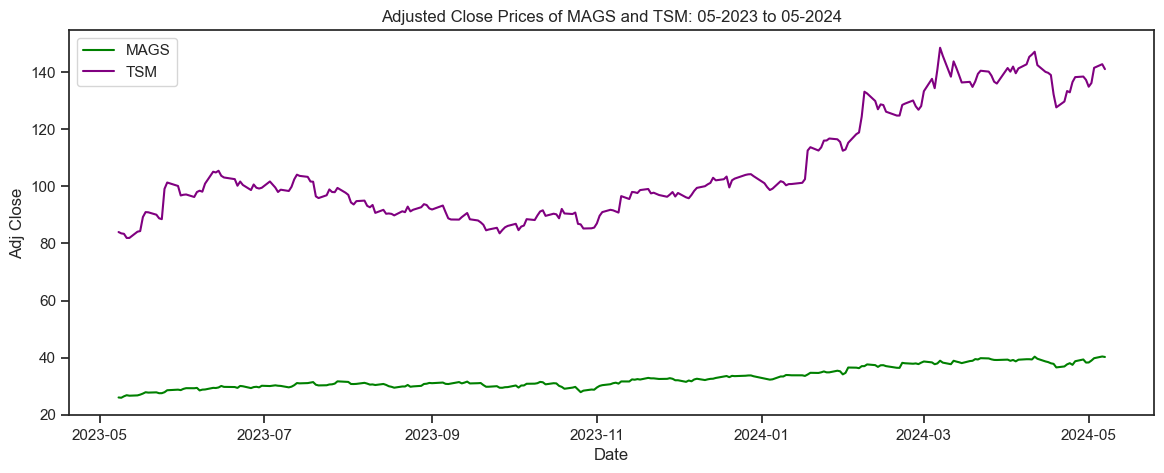

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(14,5))
    sns.set_style("ticks")
    sns.lineplot(data=mag7_data, x="Date", y='Adj Close', color='green', label='MAGS')
    sns.lineplot(data=tsm_data, x="Date", y='Adj Close', color='purple', label='TSM')
    plt.title('Adjusted Close Prices of MAGS and TSM: 05-2023 to 05-2024')
    plt.legend()
    plt.show()

By just looking at this graph, we cannot visually see much correlation between the two stocks. This may be because the adjusted close stock prices for TSM vary on a bigger range over the year than the MAGS adjusted close prices. Let's do a more in-depth analysis using Pearson's correlation coefficient to see the relationship between the adjusted close prices of both of the stocks.

Pearson's correlation coefficient: 0.9396902814871979


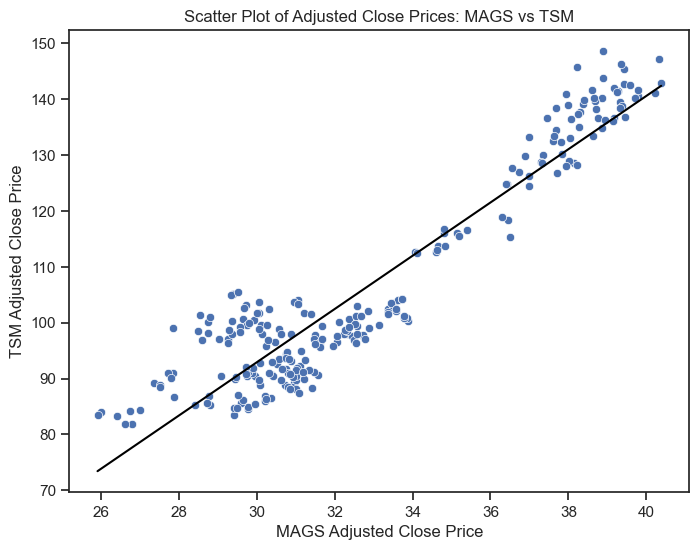

In [12]:
mags_close = mag7_data['Adj Close']
tsm_close = tsm_data['Adj Close']

correlation = np.corrcoef(mags_close, tsm_close)[0, 1]
print("Pearson's correlation coefficient:", correlation)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=mags_close, y=tsm_close)
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(mags_close, tsm_close)
x_values = np.linspace(min(mags_close), max(mags_close), 100)
y_values = slope * x_values + intercept
plt.plot(x_values, y_values, color='black', label=f'Linear Regression (R={correlation:.2f})')
plt.title('Scatter Plot of Adjusted Close Prices: MAGS vs TSM')
plt.xlabel('MAGS Adjusted Close Price')
plt.ylabel('TSM Adjusted Close Price')
plt.show()

The high correlation coefficient obtained from a Pearson correlation test between the prices of Magnificent 7 and TSM (Taiwan Semiconductor Manufacturing Company) suggests a strong linear relationship between the two stocks. In the context of the Magnificent Seven movement, this high correlation could indicate several interconnected factors. Firstly, it reflects common industry trends that heavily influence the semiconductor sector, such as technological advancements, shifts in demand for electronic devices, and broader economic conditions. Secondly, it may reflect the intricate supply chain dependencies within the semiconductor industry, given TSM's role as a significant manufacturer of chips for various companies, including Nvidia and Apple. Changes in TSM's performance or production capacity could significantly impact Nvidia's operations, as a result affecting investor sentiment for both firms. Additionally, the correlation could mirror shared market sentiment towards the semiconductor industry as a whole, where positive or negative news may affect both Nvidia and TSM's stock prices concurrently.

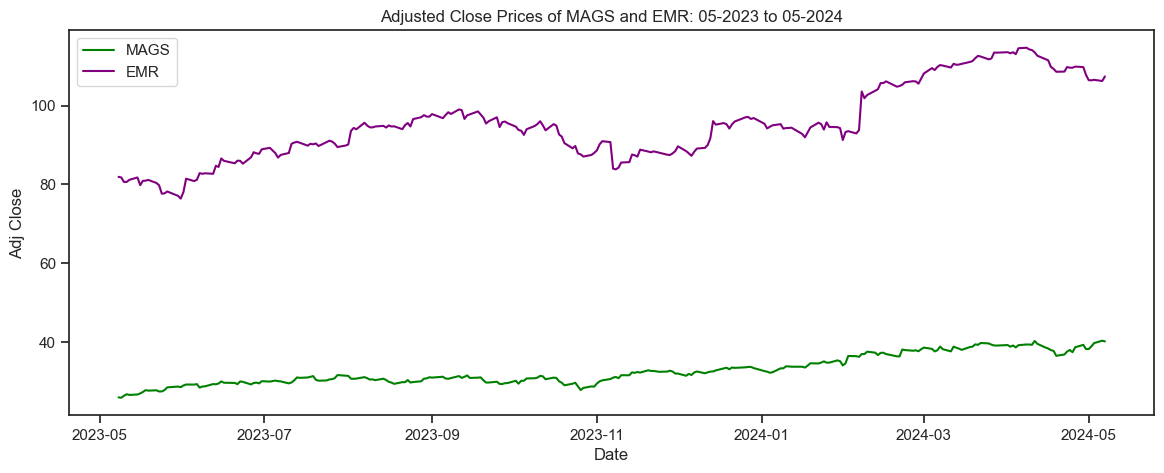

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(14,5))
    sns.set_style("ticks")
    sns.lineplot(data=mag7_data, x="Date", y='Adj Close', color='green', label='MAGS')
    sns.lineplot(data=emr_data, x="Date", y='Adj Close', color='purple', label='EMR')
    plt.title('Adjusted Close Prices of MAGS and EMR: 05-2023 to 05-2024')
    plt.legend()
    plt.show()

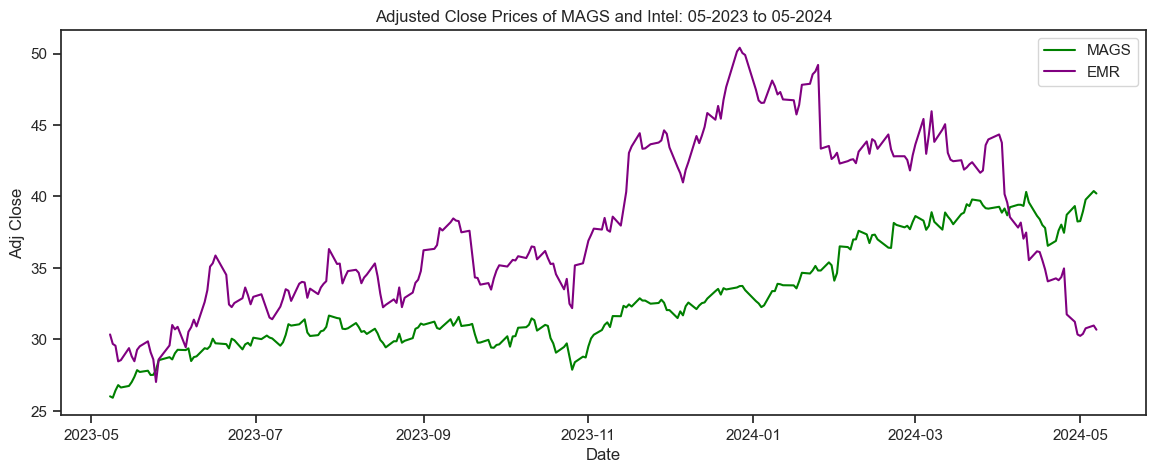

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(14,5))
    sns.set_style("ticks")
    sns.lineplot(data=mag7_data, x="Date", y='Adj Close', color='green', label='MAGS')
    sns.lineplot(data=intel_data, x="Date", y='Adj Close', color='purple', label='EMR')
    plt.title('Adjusted Close Prices of MAGS and Intel: 05-2023 to 05-2024')
    plt.legend()
    plt.show()

#### Technical Indicators

We are now calculating technical indicators using the pandas_ta library. This library streamlines the process of calculating these indicators, giving us more time to concentrate on getting insights and creating visualizations. Technical analysis involves scrutinizing historical market data, such as price and volume, to forecast future price movements. Technical indicators are mathematical calculations derived from market data, that are used to help traders and analysts in making informed trading decisions.

The indicators we're adding encompass a range of values that represent different parts of the stock and market. The Awesome Oscillator (AO) informs us of market momentum by comparing moving averages of the price. Moving Average Convergence/Divergence (MACD) highlights the relationship between two moving averages, indicating trend direction. Relative Strength Index (RSI) measures the speed and change of price movements which can be used in identifying overbought or oversold stocks. On Balance Volume (OBV) utilizes the volume flow to predict price movements. Average True Range (ATR) assesses the volatility of the market, and the Average Directional Index (ADX) quantifies the strength of a trend that the stock follows. By calculating these indicators, we can understand the market dynamics, potentially spotting trading opportunities much better. These technical indicators, if informative enough, can be used as features in our stock prediction model.

In [14]:
mag7_data.ta.ao(append=True) # Awesome Oscillator
mag7_data.ta.macd(append=True) # Moving Average Convergence/Divergence
mag7_data.ta.rsi(append=True) # Relative Strength Index
mag7_data.ta.obv(append=True) # On Balance Volume
mag7_data.ta.atr(append=True) # Average True Range
mag7_data.ta.adx(append=True) # Average Directional Index

ADX_14     DMP_14     DMN_14
Date                                       
2023-05-08        NaN        NaN        NaN
2023-05-09        NaN        NaN        NaN
2023-05-10        NaN        NaN        NaN
2023-05-11        NaN        NaN        NaN
2023-05-12        NaN        NaN        NaN
...               ...        ...        ...
2024-05-01  17.664434  28.998655  28.938062
2024-05-02  16.410159  27.106308  27.049669
2024-05-03  16.146042  32.294417  25.009626
2024-05-06  16.287598  34.285377  23.762552
2024-05-07  16.515656  33.918155  22.857939

[252 rows x 3 columns]

#### RSI Indicator

Below we plot the RSI indicator to visualize the state of the ETF.

Text(0.5, 1.0, 'RSI Indicator')

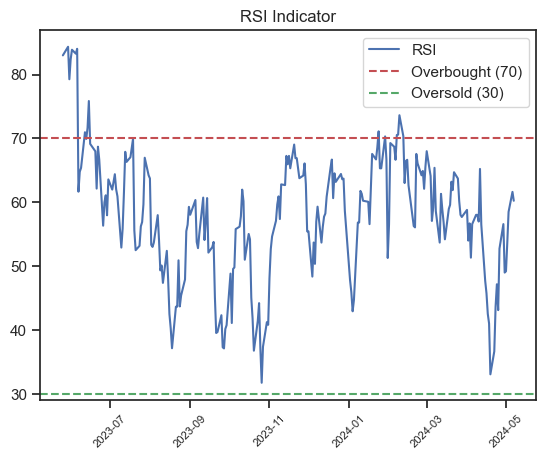

In [15]:
plt.plot(mag7_data['RSI_14'], label='RSI')
plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
plt.legend()

plt.xticks(rotation=45, fontsize=8)
plt.title('RSI Indicator')

Here the Relative Strength Index (RSI) falls within the normal range, and that suggests a balanced market sentiment without any extreme bullishness or bearishness. This basically means that there is no extreme movement in either direction, a stable price. In such instances, the RSI value usually oscillates between 30 and 70. A normal RSI indicates a stable trend. It suggests that the market is in a state of equilibrium, with neither side exerting overwhelming pressure. The RSI is not as extreme and may not be useful in a prediction for this ETF.

#### MACD Indicator

Calculating the Moving Average Convergence Divergence (MACD) provides us valuable insights into the Magnificent Seven ETF's historical market performance. The MACD is computed by taking the difference between two Exponential Moving Averages (EMAs), usually it is a shorter-term EMA (12-day) and a longer-term EMA (26-day). This calculation highlights the momentum and trend changes in the ETF's price movements over time. Interpreting the MACD involves looking at and following its relationship with a signal line, which is usually a 9-day EMA of the MACD line itself. When the MACD line crosses above the signal line, it indicates a bullish crossover, suggesting a potential uptrend in the market and in the ETF's price. on the Other hand, when the MACD line crosses below the signal line, it signals a bearish crossover, indicating a downtrend.

Note: A moving average is a  calculation used to smooth out the changes in data by creating a constantly updated average of recent historical prices or values over a specific time period. It helps to identify trends by reducing noise or random changes in the data, making it easier to visualize the underlying direction of the trend. In finance, moving averages are commonly applied to stock prices to analyze price movements over time and identify potential entry or exit points in the market.

In [16]:
plotly.offline.init_notebook_mode()

fig = go.Figure()

fig.add_trace(go.Scatter(x=mag7_data.index, y=mag7_data['MACD_12_26_9'], mode='lines', name='MACD'))
fig.add_trace(go.Scatter(x=mag7_data.index, y=mag7_data['MACDs_12_26_9'], mode='lines', name='Signal'))

fig.add_trace(go.Bar(x=mag7_data.index, y=mag7_data['MACDh_12_26_9'], name='MACD Histogram', marker_color=['green' if val >= 0 else 'red' for val in mag7_data['MACDh_12_26_9']]))

# Customize the chart
fig.update_xaxes(rangeslider=dict(visible=False))
fig.update_layout(plot_bgcolor='#efefff', font_family='Monospace', font_color='#000000', font_size=20,width=1000)
fig.update_layout(title="MACD chart for Magnificent Seven ETF")
fig.show()

In this analysis of the MACD, we observe a bullish crossover between the MACD line and the signal line and this confirms a bullish trend in the ETF's future price movement. This presents an opportunity for profit as we may consider entering or holding positions in the ETF with hopes of further price growth. By examining the historical MACD plot, we can gain valuable insights into past trend changes and momentum shifts of the fund. Overall, using this MACD analysis enhances our understanding of the Magnificent Seven ETF's market changes.

### Primary Analysis

Choose a machine learning technique to hlep answer the questions


### Visualization

Add at least one plot (labeled with legend) and explained.

### Insights and Conclusions